### Import Packages


In [1]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.__version__)

1.7.0


### MNIST dataset is provided in default

In [2]:
train_path = './mnist_train_small.csv'
test_path = './mnist_test.csv'
img_size = 28

### Choose your device - use GPU or not?

In [3]:
# device = 'cpu'
device = 'cuda'
print('Current Device : {}'.format(device))

Current Device : cuda


### Read the MNIST dataset
- total 1 (label)+ 28x28 dimension. 1 For Label, 28**2 for image


In [4]:
def mnist_reader(file_path, img_size=img_size):
    total_img = list()
    total_label = list()
    with open(file_path) as csvfile:
        mnist_reader = csv.reader(csvfile)
        for row in tqdm(mnist_reader):
            img = np.array(row[1:], dtype=np.uint16).reshape(img_size, img_size)
            img = img / 255
            label = int(row[0])

            total_img.append(img)
            total_label.append(label)

    total_img = np.asarray(total_img)
    total_label = np.asarray(total_label)
    
    return total_img, total_label

In [5]:
train_img, train_label = mnist_reader(train_path)
test_img, test_label = mnist_reader(test_path)

### Define the Dataset

In [6]:
len(train_img)

20000

In [7]:
len(test_img)

10000

### Define the DataLoader

In [8]:
class MNIST_Dataset(Dataset):
    def __init__(self, target_img, target_label):
        self.target_img = target_img
        self.target_label = target_label
        self.num_data = target_img.shape[0]

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        sample = dict()
        sample['img'] = self.target_img[idx]
        sample['label'] = self.target_label[idx]

        return sample

In [9]:
batch_size = 64

train_dataset = MNIST_Dataset(train_img, train_label)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### Try to sample out one data point from dataloader

In [10]:
sample = next(iter(train_dataloader))
print(sample['img'].shape)
print(sample['label'].shape)

torch.Size([64, 28, 28])
torch.Size([64])


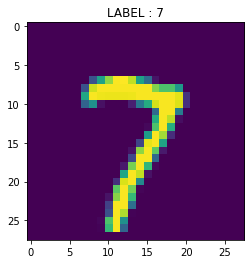

In [11]:
plot_idx = 0
plt.imshow(sample['img'][plot_idx])
plt.title('LABEL : {}'.format(sample['label'][plot_idx]))
plt.show()

### Define the VAE (encoder + decoder)

In [12]:
class VAE(nn.Module):
    def __init__(self, dim_hidden_1, dim_hidden_2, dim_z, dim_input=img_size**2):
        super(VAE, self).__init__()
        
        # define hidden dimension
        self.dim_hidden_1 = dim_hidden_1
        self.dim_hidden_2 = dim_hidden_2
        self.dim_z = dim_z
        self.dim_input = dim_input

        # define encoder
        self.enc_1 = nn.Linear(self.dim_input, self.dim_hidden_1)
        self.enc_2 = nn.Linear(self.dim_hidden_1, self.dim_hidden_2)
        self.enc_z_mean = nn.Linear(self.dim_hidden_2, self.dim_z)
        self.enc_z_logvar = nn.Linear(self.dim_hidden_2, self.dim_z) 
        
        # define decoder
        self.dec_1 = nn.Linear(self.dim_z, self.dim_hidden_2)
        self.dec_2 = nn.Linear(self.dim_hidden_2, self.dim_hidden_1)
        self.dec_3 = nn.Linear(self.dim_hidden_1, self.dim_input)
        
        self.activation = nn.ReLU()

    def encoder(self, img):
        '''
        input : img
        output : z_mean, z_logvar
        '''
        batch_size = img.shape[0]
        img = img.view(batch_size, -1)
        out = self.activation(self.enc_1(img))
        out = self.activation(self.enc_2(out))
        z_mean = self.enc_z_mean(out)
        z_logvar = self.enc_z_logvar(out)
        
        return z_mean, z_logvar

    def sampling(self, mean, logvar):
        '''
        input : mean, logvar
        output : z_sample
        '''
        eps = torch.randn_like(mean).to(device)
        std = torch.exp(0.5*logvar)
        
        z_sample = mean + torch.mul(eps,std)
        return z_sample
        
    def decoder(self, z_sample):
        '''
        input : z_sample
        output : recon_img
        '''
        out = self.activation(self.dec_1(z_sample))
        out = self.activation(self.dec_2(out))
        out = self.dec_3(out)
        return torch.sigmoid(out)

    def forward(self, img):
        '''
        input : img
        output : recon_img, z_mean, z_logvar
        '''
        z_mean, z_logvar = self.encoder(img)
        z_sample = self.sampling(z_mean, z_logvar)
        recon_x = self.decoder(z_sample)
        return recon_x, z_mean, z_logvar

### Define the Model

In [13]:
dim_hidden_1 = 512
dim_hidden_2 = 256
dim_z = 128
model = VAE(dim_hidden_1, dim_hidden_2, dim_z)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
print(model)

VAE(
  (enc_1): Linear(in_features=784, out_features=512, bias=True)
  (enc_2): Linear(in_features=512, out_features=256, bias=True)
  (enc_z_mean): Linear(in_features=256, out_features=128, bias=True)
  (enc_z_logvar): Linear(in_features=256, out_features=128, bias=True)
  (dec_1): Linear(in_features=128, out_features=256, bias=True)
  (dec_2): Linear(in_features=256, out_features=512, bias=True)
  (dec_3): Linear(in_features=512, out_features=784, bias=True)
  (activation): ReLU()
)


In [14]:
sample['img'].shape

torch.Size([64, 28, 28])

In [15]:
sample_output = model(sample['img'].float().to(device))

In [23]:
sample_output[0].shape #recon_img

torch.Size([64, 784])

In [24]:
sample_output[1].shape #mean

torch.Size([64, 128])

### eqn (10) in paper is...
$\mathcal{L}(\theta, \phi, \mathbf{x}^{(i)}) \simeq \frac{1}{2} \sum_{j=1}^{J} \Big(1 + log((\sigma_j^{(i)})^2)-(\mu_j^{(i)})^2-(\sigma_j^{(i)})^2 \Big)+ \frac{1}{L} \sum_{l=1}^{L} \log p_\theta(\mathbf{x}^{(i)} | \mathbf{z}^{(i, l)})$ 

* We need to do something to increase this lower bound

In [25]:
def criterion(recon_img, img, z_mean, z_logvar):
    '''
    IMPLEMENT 
    - BCE_Loss between recon_img and img (use F.binary_cross_entropy)
    - KL_term = REFER ABOVE
    '''
    batch_size = img.shape[0]
    BCE_Loss = F.binary_cross_entropy(recon_img, img.view(batch_size, -1), reduction='sum')
    KL_term = -0.5 * torch.sum(1 + z_logvar - z_mean**2 - torch.exp(z_logvar))
    
    return BCE_Loss + KL_term

### Define functions for train/test

In [26]:
def train(model, optimizer, sample):
    model.train()
    optimizer.zero_grad()

    img = sample['img'].float().to(device)
    
    recon_img, z_mean, z_logvar = model(img)

    curr_loss = criterion(recon_img, img, z_mean, z_logvar)

    curr_loss.backward()
    optimizer.step()

    return curr_loss.item()

In [27]:
def test(model):
    model.eval()
    with torch.no_grad():
        z_sample = torch.randn(1, dim_z).to(device)
        gen_out = model.decoder(z_sample)

    return gen_out.view(img_size, img_size).detach().cpu().numpy()

### Run Training

In [28]:
max_epoch = 100

for epoch in tqdm(range(max_epoch)):        
    ###Train Phase
    
    # Initialize Loss
    train_loss = 0.0

    # Iterate over the train_dataloader
    for idx, sample in enumerate(train_dataloader):
        curr_loss = train(model, optimizer, sample)
        train_loss += curr_loss / len(train_dataloader)
        
    print('[EPOCH {}] SAMPLED TRAINING LOSS : {}'.format(epoch, train_loss))

[EPOCH 0] SAMPLED TRAINING LOSS : 16312.76603840105
[EPOCH 1] SAMPLED TRAINING LOSS : 12684.309470472246
[EPOCH 2] SAMPLED TRAINING LOSS : 12347.009480144268
[EPOCH 3] SAMPLED TRAINING LOSS : 11931.787025134783
[EPOCH 4] SAMPLED TRAINING LOSS : 11587.583004692495
[EPOCH 5] SAMPLED TRAINING LOSS : 11103.441403129993
[EPOCH 6] SAMPLED TRAINING LOSS : 10556.880080932999
[EPOCH 7] SAMPLED TRAINING LOSS : 10326.900905426317
[EPOCH 8] SAMPLED TRAINING LOSS : 10130.773975701377
[EPOCH 9] SAMPLED TRAINING LOSS : 9955.366345097844
[EPOCH 10] SAMPLED TRAINING LOSS : 9785.279981716756
[EPOCH 11] SAMPLED TRAINING LOSS : 9644.42571572983
[EPOCH 12] SAMPLED TRAINING LOSS : 9531.984470160249
[EPOCH 13] SAMPLED TRAINING LOSS : 9420.700444913138
[EPOCH 14] SAMPLED TRAINING LOSS : 9314.910309130388
[EPOCH 15] SAMPLED TRAINING LOSS : 9214.57303626698
[EPOCH 16] SAMPLED TRAINING LOSS : 9117.948480868115
[EPOCH 17] SAMPLED TRAINING LOSS : 9017.370703749002
[EPOCH 18] SAMPLED TRAINING LOSS : 8922.8125624001

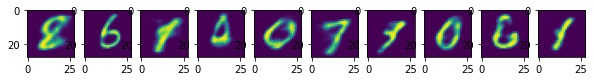

In [29]:
fig, ax = plt.subplots(1, 10, figsize=(10, 3))
for i in range(10):
    ax[i].imshow(test(model))